## Estimation de la vigueur de l'épidémie à la fin du confinement

le code de ce notebook est  disponible sur [https://github.com/didier-devel/confinement](https://github.com/didier-devel/confinement) 

Après l'annonce de la date du 11 mai pour la sortie du confinement, au moins pour les élèves et les enseignants, je me suis demandé s'il était possible d'estimer la vigueur de l'épidémie à cette date. Il y a peu de données fiables sur le nombre de personnes infectées par le virus, mais les [données des urgences hospitalières et de SOS médecins relatives à l'épidémie de COVID-19](https://www.data.gouv.fr/fr/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/), publiées sur data.gouv.fr semblent assez fiable en particulier pour dénombrer les formes graves. 

Pour estimer la vigueur de l'épidémie, l'idée est que les entrées à l'hôpital suivent, en décalé, le nombre de contaminations (ou plutôt un petit pourcentage des contaminations, la majorités des contaminations ne faisant, heureusement, pas de forme grave). Si le nombre de contaminations suit une loi exponentielle, alors le nombre d'entrées à l'hôpital devrait suivre la même loi, et la courbe devrait apparaître comme un droite quand elle est affichée avec une échelle logarithmique.

Dans ce notebook, je ne tenterai pas d'estimer le nombre réel de contaminations, mais seulement la partie de ces contaminations qui nécessitera une hospitalisation. L'idée est que le nombre réel de contaminations lui est proportionnel, avec un facteur que les données utilisées ne permet pas de mesurer.

L'hypothèse que la courbe des entrées à l'hôpital suit une loi exponentielle est plutôt confirmée par les données. En utilisant le fichier "Données quotidiennes de SOS médecins et des urgences hospitalières par département, sexe et tranche d’âge des patients", on peut établir, chaque jour, pour toutes les tranches d'âge confondues, le nombre de patients consultant les urgences ou SOS médecin qui sont hospitalisés chaque jour. La courbe des hospitalisations quotidiennes en France est affichée ci-dessous, avec une échelle logarithmique.


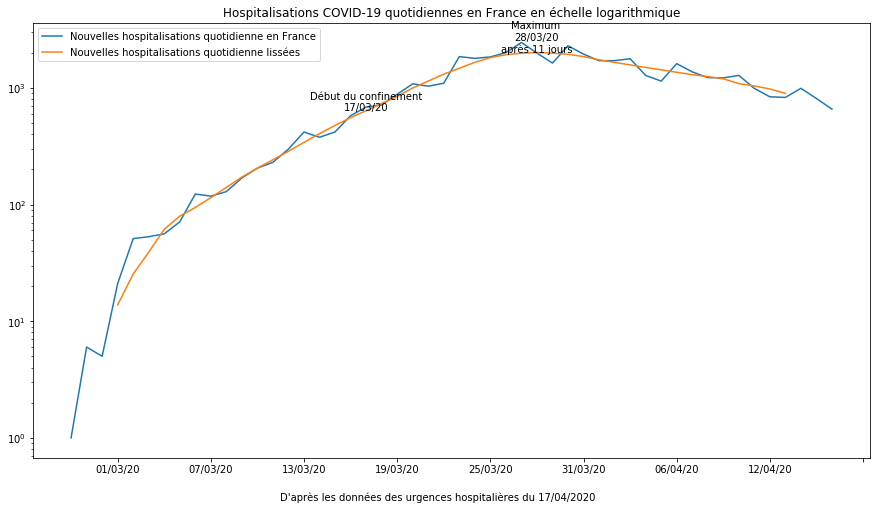

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

%matplotlib inline

df = pd.read_csv("../datagouv/sursaud-covid19-quotidien-2020-04-17-19h00-departement.csv")
data_date = "17/04/2020"

#extraire les données toutes classe d'age
all_age = df[df["sursaud_cl_age_corona"] == "0"]

# Pivot par jour - somme (sur tous les départements)
data_france = all_age.groupby(["date_de_passage"]).agg('sum')

# Afficher les dates au format jj/mm/yy et les mettre en index
def convertDate(isodate):
    l = isodate.split('-')
    return l[2]+"/"+l[1]+"/"+l[0][2:]

data_france["date"] = data_france.index
data_france["date"] = data_france["date"].apply(convertDate)
data_france = data_france.set_index(["date"])

# Remplacer les valeurs nulles par na (pour ne pas perturber la vue en echelle logarithmique)
data_france[data_france["nbre_hospit_corona"] == 0] = np.nan

# Calculer une moyenne glissante géométrique, centrée, avec une fenêtre de 7 pour lisser
# la courbe des hospitalisations quotidiennes
data_france["rolling_hospit_corona"] = data_france["nbre_hospit_corona"].rolling(7,center=True).aggregate(lambda x: x.prod()**(1./7))

# Détermination du pic des hospitalisations sur la courbe lissée
peak = data_france["rolling_hospit_corona"].idxmax()
peak_loc = data_france.index.get_loc(peak)

confinement_start = "17/03/20"
start_loc = data_france.index.get_loc(confinement_start)

# Afficher les courbes
fig = plt.figure(figsize=(15,8))
ax = plt.axes()

ax.plot(data_france["nbre_hospit_corona"], label="Nouvelles hospitalisations quotidienne en France")
ax.plot(data_france["rolling_hospit_corona"], label="Nouvelles hospitalisations quotidienne lissées")

ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_title("Hospitalisations COVID-19 quotidiennes en France en échelle logarithmique")

ax.text(start_loc,data_france["rolling_hospit_corona"].loc[confinement_start],"Début du confinement\n%s"%confinement_start,horizontalalignment="center")
ax.text(peak_loc,data_france["rolling_hospit_corona"].loc[peak],"Maximum \n%s\naprès %i jours"%(peak,peak_loc-start_loc),horizontalalignment="center")

ax.legend()
plt.yscale("log")

fig.text(.5, .05, "D'après les données des urgences hospitalières du %s"%data_date, ha='center')

#No text output
None

La courbe dite des "hospitalisations quotidiennes lissée" est en fait une moyenne géométrique glissante sur les données brutes. La moyenne glissante est centrée et est faite sur 7 points (3 avant, 3 après). Cela donne un résultat remarquable, la courbe étant bien linéaire sur les phases de montée et de descente. J'ai choisi une moyenne géométrique car une telle moyenne glissante laisse une courbe exponentielle inchangée.

Cette courbe lissée montre donc une phase montante, où le nombre d'hospitalisations est en croissance, avec une loi exponentielle (qui apparaît comme linéaire en échelle logarithmique), et une phase descendante où le nombre d'hospitalisations quotidienne est en décroissance, aussi avec une loi exponentielle.

### Indication sur la durée d'incubation
Le sommet de la courbe est atteint le 28 mars, 11 jours après le début confinement. En supposant que le nombre de nouvelles contaminations, lui , a commencé à se réduire dès le premier jour du confinement, et que la plupart des personnes hospitalisées avant le sommet de la courbe ont été contaminées avant le confinement, on peut en déduire que, dans les cas de COVID-19 qui nécessitent une hospitalisation, la durée d'incubation entre la contamination et le déclenchement d'une forme grave est d'environ 11 jours.

### Il y a toujours des contaminations pendant le confinement
Le fait qu'il y ait encore des hospitalisations dues au COVID-19 plus d'un mois après le début du confinement suggère qu'il y a des contaminations pendant la période de confinement. La courbe des hospitalisations étant décroissante, on peut en déduire que la propagation est très lente, et toute personne malade ne transmet pas forcément le virus à une autre pendant qu'elle est contagieuse, et que celles qui le transmettent le transmettent à un petit nombre (moins d'une transmission par personne en moyenne).

Dans la suite, on fera l'hypothèse simplificatrice que toute entrée à l'hôpital correspond à une contamination 11 jours plus tôt. Cela permettra d'estimer la vigueur de l'épidémie.

### Indication sur le rythme de progression et de ralentissement
Cette courbe donne aussi une idée de la vitesse de propagation de l'épidémie avant le confinement, et de son rythme de ralentissement avec le confinement. Il est en effet possible de déduire de la pente de la courbe, le temps nécessaire pour que le nombre d'hospitalisations double (dans la phase montante), et le temps nécessaire pour que le nombre d'hospitalisations se réduise réduise de moitié (dans la phase descendante).

In [2]:

def timeToDouble(period_start,period_end):
    # Estime le nombre de jours pour doubler sur la période donnee
    nb_hosp_start = data_france["rolling_hospit_corona"].loc[period_start]
    nb_hosp_end = data_france["rolling_hospit_corona"].loc[period_end]
    duration = data_france.index.get_loc(period_end) - data_france.index.get_loc(period_start)
    exponent = (math.log(nb_hosp_end) - math.log(nb_hosp_start))/duration
    return math.log(2)/exponent
    
def to_ddhh(days):
    dd = int(math.floor(days))
    hh = int((days - math.floor(days))*24)
    return "%i jours et %iH"%(dd,hh)
    
periodPattern = "Période du %s au %s"
periods=[]
rythm = []

# Période de montée du 7 mars au 21 mars
p1s = "11/03/20"
p1e = "21/03/20"
p1 = timeToDouble(period_start = p1s,period_end = p1e)
periods.append(periodPattern%(p1s,p1e))
rythm.append("Double tous les %s"%to_ddhh(p1))

p2s = "03/04/20"
p2e = "11/04/20"
# time to reduce by two is the opposite of the time to double
p2 = - timeToDouble(period_start = p2s,period_end = p2e)
periods.append(periodPattern%(p2s,p2e))
rythm.append("Réduites de moitié tous les %s"%to_ddhh(p2))

# check
#p1, data_france["rolling_hospit_corona"].loc[p1s], data_france["rolling_hospit_corona"].iloc[data_france.index.get_loc(p1s)+int(p1)],data_france["rolling_hospit_corona"].iloc[data_france.index.get_loc(p1s)+int(p1)+1]
 
periods,rythm
    
rythmes = pd.DataFrame()
rythmes["Périodes"] = periods
rythmes["Evolution des hospitalisations"] = rythm
rythmes.set_index("Périodes", inplace=True)

rythmes

,Evolution des hospitalisations
Périodes,
Période du 11/03/20 au 21/03/20,Double tous les 4 jours et 11H
Période du 03/04/20 au 11/04/20,Réduites de moitié tous les 13 jours et 8H


### Extrapolation et estimation de la vigueur de l'épidémie le 11 mai

Pour estimer la vigueur de l'épidémie à la date du 11 mai, il suffit d'extrapoler la courbe des hospitalisations. C'est ce qui est fait ci-dessous avec un affichage de l'intervalle de confiance de la régression linéaire.

On peut se faire aussi une idée du nombre de nouvelles contaminations. En supposant que la durée d'incubation d'une forme du COVID-19 nécessitant une hospitalisation est en moyenne de 11 jours - ce que suggère le pic d'hospitalisations 11 jours après le début du confinement - alors on peut penser que les nouvelles contaminations sont proportionnelles à la courbe des hospitalisations, décalée de 11 jours. On ne connaît pas toutes les nouvelles contaminations, mais on peut estimer la fraction (quelques pourcents du nombre total a priori) de celles qui nécessiteront une hospitalisation. 

Les courbes ci-dessous montrent ces estimations. La première courbe avec une échelle logarithmique, la seconde avec une échelle linéaire.

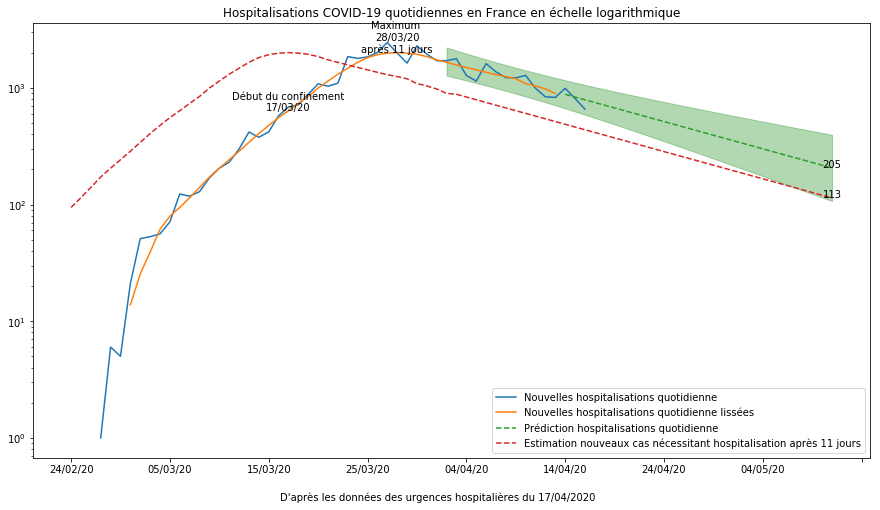

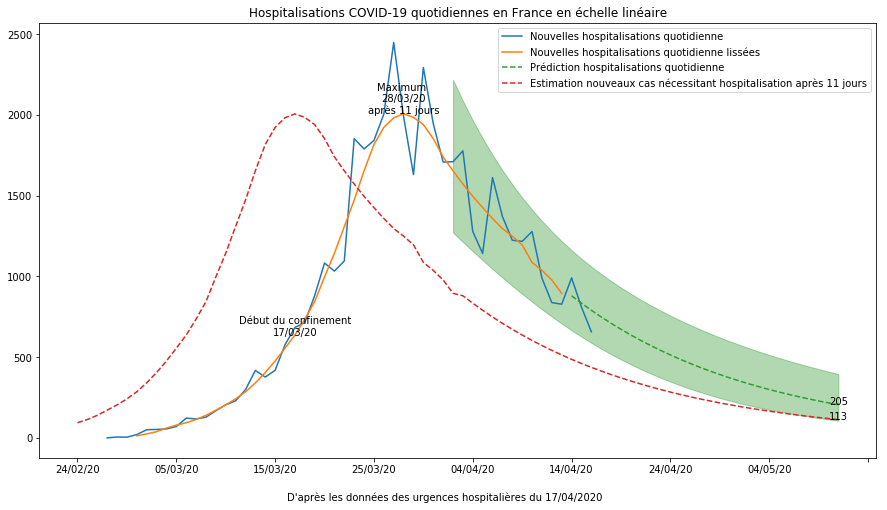

In [3]:
from datetime import date, timedelta
from sklearn.linear_model import LinearRegression
import scipy

# Agrandissement du dataframe jusqu'au 11 mai
# Etendre les dates
d = data_france.index[-1]
a = d.split("/")
dd = int(a[0])
mm = int(a[1])
yy = 2000 + int(a[2])
first = date(yy,mm,dd)+ timedelta(days=1)
last = date(2020,5,11)

current = first
indexExtension  = []
while current  <= last:
    ds = str(current.day)
    if len(ds) == 1:
        ds = '0'+ds
    ms = str(current.month)
    if len(ms) == 1:
        ms = '0'+ms
    ys = str(current.year)[2:]
    di = ds + '/' + ms + '/' + ys
    indexExtension.append(di)
    current += timedelta(days = 1)

data_france = data_france.reindex(index = data_france.index.append(pd.Index(indexExtension)))

# Ajouter une colonne de numéro de jour
data_france["jour"] = np.arange(len(data_france))

# Sélectionner les données à partir de 2 avril (5 jours après le maximum)
for_regression = data_france.iloc[peak_loc+5:]
# Eliminer les jours sans données
for_regression = for_regression[for_regression["nbre_hospit_corona"] >= 0]
# Enlever aussi les deux derniers jours - car tous les chiffres ne sont pas toujours remontés
for_regression = for_regression.loc[for_regression.index[:-2]]

# Faire une régression linéaire sur les données
reg = LinearRegression()
X_train = for_regression.drop(columns = [c for c in for_regression.columns if c != "jour"])
Y_train = np.log(for_regression["nbre_hospit_corona"])
reg.fit(X_train,Y_train)

# Ajouter la prédiction dans les données
data_france["pred_hosp"]=np.nan
# Plage de prédiction: dans la phase descendante
predIndex = data_france[data_france["jour"] >= X_train.iloc[0]["jour"]].index
X = data_france.loc[predIndex].drop(columns = [c for c in data_france.columns if c != "jour"])
data_france.loc[predIndex,"pred_hosp"]=np.exp(reg.predict(X))

# Calcul de l'intervalle de confiance de la prédiction
# Voir http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/IAAAM2/SlidesModStat_C1_print.pdf
def estimateSigma(reg, X, Y):
    Y_pred = reg.predict(X)
    err = (Y - Y_pred)**2
    return math.sqrt(err.sum() / (len(err) - 2))

sigma = estimateSigma(reg,X_train,Y_train)
X_train_mean = X_train["jour"].mean()
# Ajout de l'intervalle de confiance en log (alpha = 10% -- 1 - alpha/2 = 0.95)
data_france["conf_log_raw"] = np.nan
# Plage pour l'intervalle de confiance: depuis les données utilisées pour la régerssion linéaire
data_france.loc[predIndex,"conf_log_raw"] = np.sqrt(1 + 1./len(X_train) + \
                                           (data_france["jour"]-X_train_mean)**2 / ((X_train["jour"]-X_train_mean)**2).sum()) * \
                                           sigma*scipy.stats.t.ppf(0.95,len(X_train)-2)
data_france["pred_max"] = data_france["pred_hosp"]*np.exp(data_france["conf_log_raw"])
data_france["pred_min"] = data_france["pred_hosp"]/np.exp(data_france["conf_log_raw"])

# Enlever les prédictions dans la zone de la courbe lissée
removePredIndex = data_france[(data_france["jour"] >= X_train.iloc[0]["jour"]) & \
                              (data_france["rolling_hospit_corona"] > 0)].index

data_france.loc[removePredIndex,"pred_hosp"] = np.nan

# Extrapolation des nouvelles contaminations qui donneront des cas graves - courbe des hospitalisations décalée de 11 jours
data_france["nv_cas"] = data_france["rolling_hospit_corona"].shift(-(peak_loc-start_loc))
# Compléter l'extrapolation par la prédiction
predIndex = data_france[np.isnan(data_france["nv_cas"])].index
X = data_france.loc[predIndex].drop(columns = [c for c in data_france.columns if c != "jour"])
X["jour"] = X["jour"] + peak_loc-start_loc
data_france.loc[predIndex, "nv_cas"] = np.exp(reg.predict(X))


def plotData(useLog = True):
    # Afficher les courbes
    fig = plt.figure(figsize=(15,8))
    ax = plt.axes()

    ax.plot(data_france["nbre_hospit_corona"], label="Nouvelles hospitalisations quotidienne")
    ax.plot(data_france["rolling_hospit_corona"], label="Nouvelles hospitalisations quotidienne lissées")
    ax.plot(data_france["pred_hosp"], "--", label="Prédiction hospitalisations quotidienne")
    ax.fill_between(data_france.index, data_france["pred_max"], data_france["pred_min"],color="green",alpha=0.3)
    ax.plot(data_france["nv_cas"], "--", label="Estimation nouveaux cas nécessitant hospitalisation après 11 jours") 
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    if useLog:
        ax.set_title("Hospitalisations COVID-19 quotidiennes en France en échelle logarithmique")
    else:
        ax.set_title("Hospitalisations COVID-19 quotidiennes en France en échelle linéaire")
        
    ax.text(start_loc,data_france["rolling_hospit_corona"].loc[confinement_start],"Début du confinement\n%s"%confinement_start,horizontalalignment="center")
    ax.text(peak_loc,data_france["rolling_hospit_corona"].loc[peak],"Maximum \n%s\naprès %i jours"%(peak,peak_loc-start_loc),horizontalalignment="center")

    ax.text(data_france.index[-1],data_france["pred_hosp"].iloc[-1],"%i"%int(data_france["pred_hosp"].iloc[-1]),horizontalalignment="center")
    
    ax.text(data_france.index[-1],data_france["nv_cas"].iloc[-1],"%i"%int(data_france["nv_cas"].iloc[-1]),horizontalalignment="center")
    
    ax.legend()
    if useLog:
        plt.yscale("log")

    fig.text(.5, .05, "D'après les données des urgences hospitalières du %s"%data_date, ha='center')

plotData(useLog=True)
plotData(useLog=False)

D'après ce modèle, au 11 mai, la vigueur de l'épidémie aura considérablement réduit. Le nombre de personnes contaminées par jour et qui devront aller à l'hôpital ne sera malheureusement pas nul, mais très inférieur à la situation au début du confinement.

In [4]:
situation = pd.DataFrame();
situation["Date"] = ["17/03/20", "11/05/20"]
situation["Hosipitalisations quotidiennes dues au COVID-19 en France"] = [int(data_france["nbre_hospit_corona"].loc["17/03/20"]),
                                               int(data_france["pred_hosp"].loc["11/05/20"])]
situation["Contaminations quotidiennes en France qui nécessiteront une hospitalisation"] = [int(data_france["nv_cas"].loc["17/03/20"]),
                                               int(data_france["nv_cas"].loc["11/05/20"])]
situation["Tendance court terme des hospitalisations quotidiennes en France"] = ["Double tous les %s"%to_ddhh(p1),
                                                                        "Réduite de moitié tous les %s"%to_ddhh(p2)]

situation.set_index("Date", inplace=True)

situation

,Hosipitalisations quotidiennes dues au COVID-19 en France,Contaminations quotidiennes en France qui nécessiteront une hospitalisation,Tendance court terme des hospitalisations quotidiennes en France
Date,,,
17/03/20,684,2006,Double tous les 4 jours et 11H
11/05/20,205,113,Réduite de moitié tous les 13 jours et 8H


### Et ensuite ?

Après la date du 11 mai, on peut imaginer que le nombre d'hospitalisations quotidiennes continuera à baisser, de même qu'il a continué à augmenter après le début du confinement pendant 11 jours, du fait du temps d'incubation du COVID-19. Puis, il évoluera en fonction de l'évolution des nouvelles contaminations à l'issue du confinement.

Il faut espérer que ces nouvelles contaminations progresseront moins vite qu'avant le confinement. 

Sinon, si elles continuent de doubler tous les 4 jours et 11H, comme c'était probablement le cas avant le confinement, l'épidémie rattrapera le niveau d'entrée en confinement en 18 jours. 

Pour que les hôpitaux ne soient pas à nouveau saturés par des milliers d'entrées par jour, et pour que chaque personne qui a besoin d'être soigné puisse l'être, il faut donc s'attendre à des changements dans nos habitudes après le déconfinement, afin de réduire la vitesse de propagation du virus.



In [6]:
maxHosp = data_france["rolling_hospit_corona"].max()
minHosp = data_france["nv_cas"].iloc[-1]

# Avec une période P1 pour doubler le nombre de cas, temps nécessaire pour aller du minimum de contaminations
# quotidienne prévu le 11 mai, au niveau d'entrée en confinement. [contamination necessitant une hospitalisation]
delay = math.log(maxHosp/minHosp)/math.log(2)*p1

message = "Sinon, si elle continue de doubler tous les %s, l'épidémie rattrapera le niveau d'entrée en confinement en %i jours" \
          % (to_ddhh(p1), int(delay))

# Copy and paste the message in markdown cell to avoid formatting issues
#message

On peut suivre l'évolution hospitalistions quotidiennes par rapport à l'estimation faite à partir des données du 17 avril sur [cette page](update.html)